In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, IFrame
import ipywidgets as widgets
from ipywidgets import interact, fixed, Dropdown, Checkbox, FloatSlider, IntSlider, Output, VBox, HBox

from numpy import cos, sin, tan, arctan, exp, log, pi, array, linspace, arange, sqrt
from numpy.linalg import norm
from mpl_toolkits import mplot3d

%matplotlib widget


# Uncomment the one that corresponds to your Jupyter theme
plt.style.use('default')
# plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# plt.style.use('Solarize_Light2')

plt.rcParams.update({
    "figure.figsize": (6,6),
    "text.usetex": True,
    "font.family": "serif",
})


$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\bv}[1]{\begin{bmatrix} #1 \end{bmatrix}}$
$\renewcommand{\vec}{\mathbf}$


In [15]:
%%html

<style>
.shadow {

    /*Edit or add new attributes, change size, color, etc */
    width: 75%;
    box-shadow: 8px 8px 10px #444;
    border: 1px solid silver;

    /*For positioning in a jupyter notebook*/
    margin-top: 2em;
    position: relative;
    top: -25px
}
</style>

<p style="padding-bottom:40%;"> </p>

## One-minute Review

The **curvature** of a curve is given by $$ \kappa = \left| \frac{d\vec T}{ds} \right| $$ where $\vec T$ is the unit tangent vector and $s$ is arc length. In other words, it measures how fast the direction of a path is changing per unit arc length. 

A circle of radius $R$ has curvature $\kappa = 1/R$, thus a smooth with nonzero curvature has an **osculating circle** at that point.

In [16]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))

    plt.ioff()
    fig = plt.figure(TITLE)
    ax = fig.add_subplot(projection='3d')
    plt.ion()
    
    r1 = lambda t: np.array([t,t**2,t**3])
    r2 = lambda t: np.array([cos(2*pi*t),sin(2*pi*t),t])
    r3 = lambda t: np.array([cos(8*pi*t),sin(3*pi*t),sin(7*pi*t)])

    ax.set_autoscale_on(True)
    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)


    slider = FloatSlider(min=-1, max=1, step=.01, value=0)
    drop = Dropdown(options={"twist":r1, "helix": r2, "wacky": r3})
    
    pl = ax.plot([], [], [], lw=3)[0]
    oc = ax.plot([], [], [], lw=3, color='y')[0]
    
    def update(change):
        while ax.collections:
            ax.collections.pop()
        r, t = drop.value, slider.value

        s = np.linspace(-1,1,300)

        X,Y,Z = np.column_stack([r(x) for x in s])
        pl.set_data_3d(X, Y, Z)
        
        ax.quiver(0,0,0,r(t)[0],r(t)[1],r(t)[2])
        v,w,x =[r(t),(r(t+.01)-r(t-.01))/.02,(r(t+.01)-2*r(t)+r(t-.01))/(.01**2)] # position, first, and second derivative
        T = w / norm(w) # unit tangent vector
        n = x - np.dot(x,T)*T
        n = n/norm(n) # unit normal vector
        k = norm(np.cross(w,x))/(norm(w)**3) # curvature 
        s = np.linspace(0,2*pi,200)
        X,Y,Z = np.column_stack([v + n/k + cos(x)*n/k +sin(x)*T/k   for x in s]) # osculating circle
        oc.set_data_3d(X,Y,Z)
        ax.quiver(v[0],v[1],v[2],T[0],T[1],T[2],color='r')
        ax.quiver(v[0],v[1],v[2],n[0],n[1],n[2],color='g')
    
    update({'new': 1})
    
    slider.observe(update, names='value')
    drop.observe(update, names='value')
    
    return widgets.VBox([HBox([drop, slider]), fig.canvas])

a("Osculating Circle")

<p style="padding-bottom:40%;"> </p>

#### Square Velocity

![Solution from HW3.5](https://drew.youngren.nyc/assets/images/square_velo.gif)

from HW3. 

<p style="padding-bottom:40%;"> </p>

# Lecture 07 - Scalar Fields

  - Objectives

    - Sketch contour plot of a function of 2 variables
    - Relate level sets to a graph
    - Explore limits and continuity of $f(x,y)$.
    - Define partial derivatives
  
  - Resources
    - Content
      - Stewart: §14.1–2
      - New Strang: [§4.1](https://cnx.org/contents/oxzXkyFi@5.30:t-PZBc8c@6/4-1-Functions-of-Several-Variables) [§4.2](https://cnx.org/contents/oxzXkyFi@5.30:2YObsFkq@7/4-2-Limits-and-Continuity)
      - [Slides](https://e2000.columbiajupyter2.org/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fdrewyoungren%2Fmvc-sp20&urlpath=tree%2Fmvc-sp20%2Fslide_notebooks%2Fmvc-L07.ipynb) via JupyterHub
    - Visualization
      - [CalcPlot3D](https://www.monroecc.edu/faculty/paulseeburger/calcnsf/CalcPlot3D/)
    - Practice
      - Mooculus: [Functions of Several Variables](https://ximera.osu.edu/mooculus/calculus3/functionsOfSeveralVariables/digInFunctionsOfSeveralVariables) [Level Sets](https://ximera.osu.edu/mooculus/calculus3/functionsOfSeveralVariables/digInLevelSets) [Continuity](https://ximera.osu.edu/mooculus/calculus3/continuityOfFunctionsOfSeveralVariables/digInContinuity)
    - Extras
      - CalcBLUE: [Multivariate Functions](https://www.youtube.com/watch?v=owMT-d4RRpw&index=4&list=PL8erL0pXF3JYm7VaTdKDaWc8Q3FuP8Sa7)

<p style="padding-bottom:40%;"> </p>

## Scalar Fields (aka Functions of Several Variables)

<div class="alert alert-block alert-info shadow">
    <strong>Definitions</strong> 
    
<p>A <b>scalar field</b> is simply a function of the type $$f:\RR^n \to \RR.$$ That is, a function that takes in a vector and spits out a scalar.</p>
    
<p>The <b>domain</b> of a function $f(x,y)$ is the set of all valid input values. We write $$\operatorname{dom} f = \{(x,y)\in \RR^2: f(x,y)\in \RR\}.$$</p>
    
<p>The <b>image</b> of a function $f(x,y)$ is the set of all valid output values. We write $$\operatorname{im} f = \{f(x,y)\in \RR: (x,y)\in \operatorname{dom} f\}.$$</p>
  
</div>

<p style="padding-bottom:40%;"> </p>

<div class="alert alert-block alert-success shadow">
    <strong>Examples</strong>
    <ul>
        <li>
<!--             <img src="https://i.pinimg.com/originals/1e/3a/55/1e3a5538e45ae81e3ead4c403b3637c0.png" style="float:right; width: 150px;"> -->
            <b>elevation:</b> $f(x,y)$ is the height in feet above sea level for point at longitude $x$ and latitude $y$.</li>
        <li><b>temperature:</b> $u(x,y,z)$ is the temperature in the room at position $\langle x, y, z\rangle$.
        </li>
        <li><b>probability density:</b> $|\Psi(\vec x, t)|^2$ gives the probability (density) of finding a particle with wave function $\Psi$ at position $\vec x$ at time $t$.</li>
    </ul>
</div>

<p style="padding-bottom:40%;"> </p>

### Formulas

Many—but not all or even most—functions can be written down with explicit formulas.

<!-- 
\begin{align*}
g(x,y) &= x^2 + 2xy+y^2 \\
h(x,y) &= e^{-x^2 -y^2} \\
f(x,y) &= \frac{x \sin 2y + y \sin 2x }{2} \\
\end{align*} -->

In [17]:
def f(x,y):
    return x**2 + 2*x*y + y**2

f(3,4)

49

In [18]:
f(1, -3)

4

In [19]:
out = widgets.Output()
v = np.array((3, 4))
with out:
    f(v) # fails with TypeError
display(out)

Output()

In [20]:
f(*v) # works

49

<div style="padding-bottom: 40%"></div>

### Plotting

Functions of two variables are good for study as they can be visualized pretty well.

<div class="alert alert-block alert-info shadow">
<strong>Definitions</strong>
<p>A <b>graph</b> of a function $f(x,y)$ is the set of points $(x,y,z) \in \RR^3$ that satisfy $z = f(x, y)$. These constitute a <em>surface</em>.</p>
<p>A <b>level curve</b> of a function $f(x,y)$ is the set of points $(x,y) \in \RR^2$ that satisfy $f(x, y) = k$ for a fixed value $k$.</p>
    <p>A <b>contour plot</b> of a function is collection of level curves plotted on the same axes.</p>
</div>



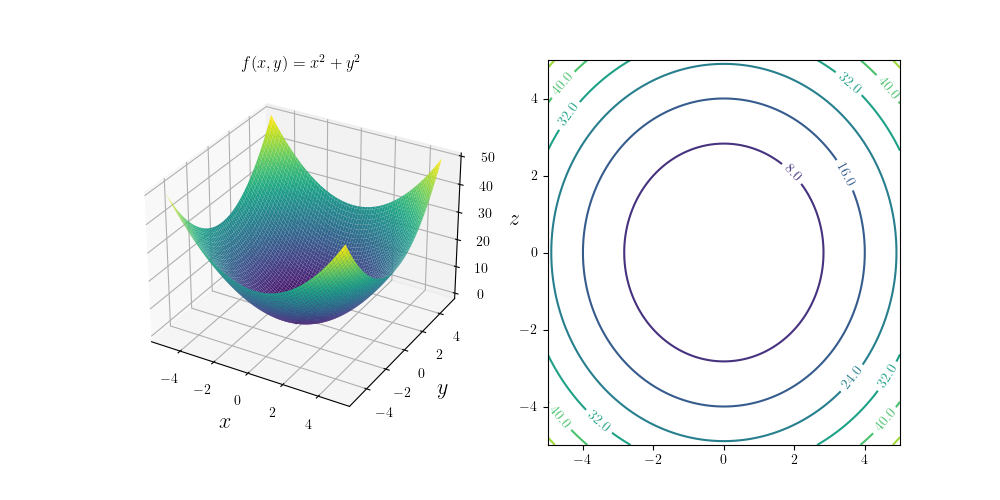

In [21]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE, figsize=(10,5))
    plt.ion()
    ax = fig.add_subplot(121, projection='3d') 
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    
    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
        
    ax.set_autoscale_on(True)

    func = lambda x,y: x**2 + y**2

    x = y = np.linspace(-1,1,400)
    X,Y = np.meshgrid(x,y)
    
    X = 5*X
    Y = 5*Y
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.set_title(r"$f(x,y) = x^2 + y^2$")
    ax.plot_surface(X,Y,Z,alpha=1,cmap='viridis',rcount=75,ccount=75);
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis');
    # fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    

    
    return fig.canvas

a("A Quadratic Function")

<div style="padding-bottom: 40%"></div>

### Examples

Sketch a few level curves (aka contours) of each of the following functions.

$$\displaystyle g(x,y) = x^2 + 2xy+y^2 \qquad h(x,y) = e^{-x^2 -y^2} \qquad f(x,y) = \frac{x \sin 2y + y \sin 2x }{2} $$

<div style="padding-bottom: 40%"></div>

In [22]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE, figsize=(12,6))
    plt.ion()
    ax = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122)

    # scale
    
    SCALA = 5
    
    # make axes lines
    ax.plot([-SCALA,SCALA],[0,0],[0,0],'gray')
    ax.plot([0,0],[-SCALA,SCALA],[0,0],'gray')
    ax.plot([0,0],[0,0],[-SCALA,SCALA],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim3d")([-SCALA,SCALA]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
#     
    ax.set_autoscale_on(True)
    
    cp = ax2.contour([[0, 1], [2, 3]], cmap='viridis');
    cl = ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    
    fw = Dropdown(options={"g":["g", lambda x,y: (x+y)**2, r"$z = (x+y)^2$"],
            "h":["h", lambda x,y: exp(-x**2 - y**2), r"$z = e^{-x^2-y^2}$"],
            "f":["f", lambda x,y: x*sin(2*y)/2 + y* sin(2*x)/2, r"$z = x\sin(2y)/2 + y \sin(2x)/2$"]},
                 label="g")
#     checker = Checkbox(value=False)
#     slider = FloatSlider(min=0, max=1, step=0.01)
    
#     def update_lev(change):
#         fname, func, fs = fw.value
#         lev, one_level = slider.value, checker.value
        
#         if one_level:        
#             k = (np.max(Z)*.999)*(lev)+(1-lev)*np.min(Z)

#             cl = ax.contour(X,Y,Z,offset=k,levels=[k],colors=['red'])

#             cl2 = ax2.contour(X,Y,Z,levels=[k],colors=['red'])
#             ax2.clabel(cp2,fmt='%1.1f'); # inline counour labels.
#         else:
#             for c in cl.collections:
#                 ax.collections.remove(c)
    
    def update_fw(change):
        fname, func, fs = fw.value
        
        # print(change)
        
        while ax.collections:
            ax.collections.pop()
        ax2.clear()
        
        x = y = np.linspace(-1,1,400)
        X,Y = np.meshgrid(x,y)
        if fname == "h":
            x = np.linspace(0,2*pi,100)
            y = np.linspace(0,1.99,100)
            x,y = np.meshgrid(x,y)
            X = y*cos(x)
            Y = y*sin(x)
            ax.set_xlim(-2,2)
            ax.set_ylim(-2,2)
            ax.set_zlim(0,2)
        else:
            X = 5*X
            Y = 5*Y
            ax.set_xlim(-5,5)
            ax.set_ylim(-5,5)
            ax.set_zlim(-5,5)
        Z = func(X,Y)

        ax.plot_surface(X,Y,Z,alpha=.5,cmap='viridis',rcount=75,ccount=75);

        ax.contour(X,Y,Z)
        
        ax.set_zlim(np.min(Z), np.max(Z))

        ax.set_title(fs,fontsize=16) 
        
        cp = ax2.contour(X,Y,Z,cmap='viridis');
        # fig.colorbar(cp); # for colorbar reference
        ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    
    fw.observe(update_fw, names='value')
    # checker.observe(update_lev, names='value')
    # slider.observe(update_lev, names='value')

    update_fw({'new': fw.value})
    
    return widgets.VBox([fw, fig.canvas])

    # return widgets.VBox([HBox([fw, checker, slider]), fig.canvas])

a("Level Curves")

<p style="padding-bottom:40%;"> </p>

## Exercises

For each function below, 
  - find the domain,
  - make a contour plot with appropriate levels, and 
  - if possible, sketch a graph.

&nbsp;
  1. $\displaystyle xy$
  1. $\displaystyle x \sin y$
  1. $\displaystyle \sqrt{4-x^2-y^2}$
  1. $\displaystyle \ln (x^2 + y^2)$
  1. $\displaystyle 2^{x-y}$

<p style="padding-bottom:40%;"> </p>

In [23]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE, figsize=(8,4))
    plt.ion()
    ax = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122)

    # scale
    
    SCALA = 3
    
    # make axes lines
    ax.plot([-SCALA,SCALA],[0,0],[0,0],'gray')
    ax.plot([0,0],[-SCALA,SCALA],[0,0],'gray')
    ax.plot([0,0],[0,0],[-SCALA,SCALA],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim3d")([-SCALA,SCALA]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)
    
    cp = ax2.contour([[0, 1], [2, 3]], cmap='viridis');
    cl = ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    
    fw = Dropdown(options={"1":["f",lambda x,y: x*y,r"$z = x y$"],
            "2":["g",lambda x,y: x*sin(y),r"$z = x \sin(y)$"],
            "3":["h",lambda x,y: sqrt(4-x**2-y**2),r"$z = \sqrt{4-x^2-y^2}$"],
            "4":["k",lambda x,y: log(x**2+y**2),r"$z = \ln (x^2+y^2)$"],
            "5":["l",lambda x,y: exp((x-y)*log(2)),r"$z = 2^{x-y}$"]},
                 label="1")
#     checker = Checkbox(value=False)
#     slider = FloatSlider(min=0, max=1, step=0.01)
    
#     def update_lev(change):
#         fname, func, fs = fw.value
#         lev, one_level = slider.value, checker.value
        
#         if one_level:        
#             k = (np.max(Z)*.999)*(lev)+(1-lev)*np.min(Z)

#             cl = ax.contour(X,Y,Z,offset=k,levels=[k],colors=['red'])

#             cl2 = ax2.contour(X,Y,Z,levels=[k],colors=['red'])
#             ax2.clabel(cp2,fmt='%1.1f'); # inline counour labels.
#         else:
#             for c in cl.collections:
#                 ax.collections.remove(c)
    
    def update_fw(change):
        fname, func, fs = fw.value
        
        # print(change)
        
        while ax.collections:
            ax.collections.pop()
        ax2.clear()
        
        x = y = np.linspace(-SCALA,SCALA,400)
        X,Y = np.meshgrid(x,y)
        if fname == "h":
            x = np.linspace(0,2*pi,100)
            y = np.linspace(0,1.99,100)
            x,y = np.meshgrid(x,y)
            X = y*cos(x)
            Y = y*sin(x)
            ax.set_xlim(-2,2)
            ax.set_ylim(-2,2)
            ax.set_zlim(0,4)
        # else:
        #     X = 5*X
        #     Y = 5*Y
        #     ax.set_xlim(-5,5)
        #     ax.set_ylim(-5,5)
        #     ax.set_zlim(-5,5)
        Z = func(X,Y)
        if fname !="h":
            ax.set_zlim(np.min(Z), np.max(Z))

        
        ax.plot_surface(X,Y,Z,alpha=.5,cmap='viridis',rcount=75,ccount=75);

        ax.contour(X,Y,Z)

        ax.set_title(fs,fontsize=16) 
        
        cp = ax2.contour(X,Y,Z,cmap='viridis', levels=12);
        # fig.colorbar(cp); # for colorbar reference
        ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    
    fw.observe(update_fw, names='value')
    # checker.observe(update_lev, names='value')
    # slider.observe(update_lev, names='value')

    update_fw({'new': fw.value})
    
    return widgets.VBox([fw, fig.canvas])

    # return widgets.VBox([HBox([fw, checker, slider]), fig.canvas])

a("Level Curves Exercises")

<p style="padding-bottom:40%;"> </p>

#### Quick exercise 

Which function of $x$ and $y$ below corresponds with the following graph?

  1. $\displaystyle \sin xy$
  1. $\displaystyle y + \sin xy$
  1. $\displaystyle e^{-(y-\sin x)^2}$
  1. $\displaystyle y - \log |\sin x|$
  

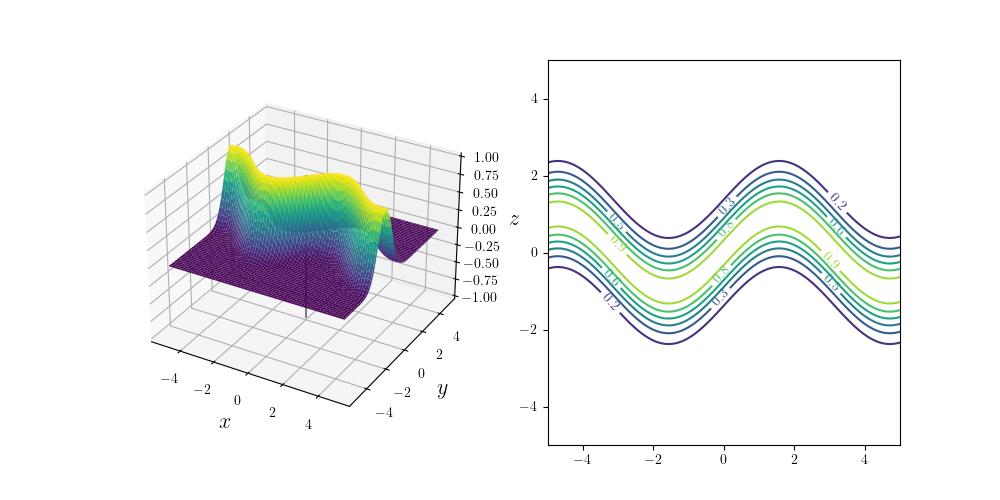

In [24]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE, figsize=(10,5))
    plt.ion()
    ax = fig.add_subplot(121, projection='3d') 
    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    
    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
        
    ax.set_autoscale_on(True)

    func = lambda x,y: exp(-(y - sin(x))**2)

    x = y = np.linspace(-1,1,400)
    X,Y = np.meshgrid(x,y)
    
    X = 5*X
    Y = 5*Y
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.plot_surface(X,Y,Z,alpha=1,cmap='viridis',rcount=75,ccount=75);
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis');
    # fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    

    
    return fig.canvas

a("Match that graph")

<p style="padding-bottom:40%;"> </p>


# Limits

Good news. As with vector-valued functions, the definition of limits goes through when applied to scalar fields

if we take the right view of their inputs. 

<p style="padding-bottom:40%;"> </p>


<div class="alert alert-block alert-info shadow">
    <strong>Definition</strong>
    
<p>Let $P\in \RR^2$ be a point. We write $$\lim_{(x,y)\to P} f(x,y) = L$$ provided $|f(x,y)-L|$ can be made arbitrarily small for all $(x,y)$ sufficently close to $P$.</p>
</div>



<p style="padding-bottom:40%;"> </p>


<div class="alert alert-block alert-warning shadow">
    <strong>Definition (Vectorized)</strong>
    
<p>Let $\vec p$ be a position vector in $\RR^n$. We write $$\lim_{\vec x\to \vec p}f(\vec x) = L$$ provided $|f(\vec x)-L|$ can be made arbitrarily small if $|\vec x - \vec p|$ is sufficiently small.</p>
</div>

<p style="padding-bottom:40%;"> </p>


## Intuition 

The first use of limits is to define continuity at a point,

$$\lim_{\vec x\to \vec p}f(\vec x) = f(\vec p),$$

but where a continuous function is one whose graph can be drawn without picking up the pencil, a continuous scalar field is one whose graph is "untorn". In other words, the function's values don't suddenly jump. 

Let's zoom in on the neighborhood of a point where a function of 2 variables is continuous.

In [25]:
def a(TITLE):
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE,figsize = (12,6))
    ax = fig.add_subplot(121,projection='3d')
    plt.ion()

    
    # make axes lines
    ax.plot([-1,1],[0,0],[0,0],'gray')
    ax.plot([0,0],[-1,1],[0,0],'gray')
    ax.plot([0,0],[0,0],[-1,1],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim")([-1,1]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)
    
    func = lambda x,y: exp(1-x**2/7-y**2/12)

    x = y = np.linspace(-4,4,400)
    X,Y = np.meshgrid(x,y)
    Z = func(X,Y)
#     ax.set_autoscale_on(True)
    ax.plot_surface(X,Y,Z,cmap='viridis',rcount=25,ccount=25,alpha=.32,vmin=0,vmax=3);
    
    pl = ax.plot_surface(X,Y,Z,cmap='viridis',rcount=75,ccount=75,alpha=1,vmin=0,vmax=3);
    ax.plot([1,1],[0,0],[0,func(1,0)],'k')
    ax2 = fig.add_subplot(122)
    cp = ax2.contour(X,Y,Z,cmap='viridis',vmin=0,vmax=3);
#     fig.colorbar(cp); # for colorbar reference
    ax2.clabel(cp,fmt='%1.1f'); # inline contour labels.
    
    def update(change):
        ax.collections.pop()
        ax2.clear()       
        h = slider.value
        r,t = np.meshgrid(np.linspace(0,h,100),np.linspace(0,2*np.pi*2, 50))
        X = r*cos(t) + 1
        Y = r*sin(t)
        Z = func(X,Y)
        ax.plot_surface(X,Y,Z,cmap='viridis',alpha=1,vmin=0,vmax=3);        
        cp = ax2.contour(X,Y,Z,cmap='viridis',vmin=0,vmax=3);
        ax2.clabel(cp,fmt='%1.1f'); # inline contour labels.
    
    slider = FloatSlider(min=0.001, max = 4, step = .001, value=4)
    slider.observe(update, names='value')
    
    return widgets.VBox([slider, fig.canvas])

a("A limit")

<p style="padding-bottom:40%;"> </p>


## Computing limits

That said, some strange things can happen. Below are several examples illustrating various phenomena related to limits in 2 variables. 

In [26]:
def a(TITLE):    
    if TITLE in plt.get_figlabels():
        plt.close(plt.figure(TITLE))
    
    plt.ioff()
    fig = plt.figure(num=TITLE, figsize=(8,4))
    plt.ion()
    ax = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122)

    # scale
    
    SCALA = 1
    
    # make axes lines
    ax.plot([-SCALA,SCALA],[0,0],[0,0],'gray')
    ax.plot([0,0],[-SCALA,SCALA],[0,0],'gray')
    ax.plot([0,0],[0,0],[-SCALA,SCALA],'gray')   

    for c in 'xyz':
        getattr(ax,f"set_{c}lim3d")([-SCALA,SCALA]);    
        getattr(ax,f"set_{c}label")(f"${c}$",size=16)
    
    ax.set_autoscale_on(True)
    
    cp = ax2.contour([[0, 1], [2, 3]], cmap='viridis');
    cl = ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.

    f = lambda x,y: x**2 + y**2
    g = lambda x,y: x*y/(x**2 + y**2)
    h = lambda x,y: x**2*y/(x**2 + y**2)
    k = lambda x,y: x**2*y/(x**4 + y**2)
    l = lambda x,y: x*y/sqrt(x**2 + y**2)
    
    fw = Dropdown(options={"1":[f,"x^2 + y^2"],
            "2":[g,"\\frac{xy}{x^2 + y^2}"],
            "3":[h,"\\frac{x^2y}{x^2 + y^2}"],
            "4":[k,"\\frac{x^2y}{x^4 + y^2}"],
            "5":[l,"\\frac{xy}{\\sqrt{x^2 + y^2}}"]},
                 label="1")
#     checker = Checkbox(value=False)
#     slider = FloatSlider(min=0, max=1, step=0.01)
    
#     def update_lev(change):
#         fname, func, fs = fw.value
#         lev, one_level = slider.value, checker.value
        
#         if one_level:        
#             k = (np.max(Z)*.999)*(lev)+(1-lev)*np.min(Z)

#             cl = ax.contour(X,Y,Z,offset=k,levels=[k],colors=['red'])

#             cl2 = ax2.contour(X,Y,Z,levels=[k],colors=['red'])
#             ax2.clabel(cp2,fmt='%1.1f'); # inline counour labels.
#         else:
#             for c in cl.collections:
#                 ax.collections.remove(c)
    
    def update_fw(change):
        func, fs = fw.value
        
        # print(change)
        
        while ax.collections:
            ax.collections.pop()
        ax2.clear()
        
        x = y = np.linspace(-SCALA,SCALA,400)
        X,Y = np.meshgrid(x,y)
        Z = func(X,Y)

        ax.set_zlim(np.min(Z), np.max(Z))
        
        ax.plot_surface(X,Y,Z,alpha=.5,cmap='viridis',rcount=75,ccount=75);

        ax.contour(X,Y,Z)

        ax.set_title(f"${fs}$",fontsize=16) 
        
        cp = ax2.contour(X,Y,Z,cmap='viridis');
        # fig.colorbar(cp); # for colorbar reference
        ax2.clabel(cp,fmt='%1.1f'); # inline counour labels.
    
    fw.observe(update_fw, names='value')
    # checker.observe(update_lev, names='value')
    # slider.observe(update_lev, names='value')

    update_fw({'new': fw.value})
    
    return widgets.VBox([fw, fig.canvas])

    # return widgets.VBox([HBox([fw, checker, slider]), fig.canvas])

a("Some Limits")

<p style="padding-bottom:40%;"> </p>

## Summary for checking limits

Rules of thumb (but not foolproof) for evaluating $$\lim_{(x,y) \to (a,b)} f(x,y)$$

<p style="padding-bottom:40%;"> </p>


#### Try plugging in

All sums, products, quotients, and compositions of continuous functions are continuous *on their domains*. 

<p style="padding-bottom:40%;"> </p>


#### Check the "cardinal" directions

That is, check $\displaystyle \lim_{x\to a} f(x,b)$ and $\displaystyle \lim_{y\to b} f(a,y)$. If they don't match or either doesn't exist, the limit as a whole does not exist.

<p style="padding-bottom:40%;"> </p>


#### Try another direction of approach

e.g., $\displaystyle \lim_{h\to 0} f(a + h,b + h)$

<p style="padding-bottom:40%;"> </p>


#### Try squeezing

Find (simpler) functions above and below the function in question. If they converge to a point, the original must as well. 

That is, if $g(x,y) \leq f(x,y) \leq h(x,y)$ in a neighborhood of $(a,b)$ and the outer limits exist and equal $L$ as $(x,y) \to (a,b)$, then $$\lim_{(x,y)\to (a,b)} f(x,y) =L.$$

<p style="padding-bottom:40%;"> </p>


#### Go polar

Try making the substitution $x= r\cos\theta, y= r\sin\theta$ and take the limit $$\lim_{r\to0^+} f(r\cos\theta,r\sin\theta).$$ 

<p style="padding-bottom:40%;"> </p>